In [12]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
import matplotlib
import scipy.sparse as sparse
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)

In [13]:
path_to_save = "../results/Figures/Supplemental Figure 5/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [14]:
pbmc = sc.read("../data/train_pbmc.h5ad")
pbmc

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [15]:
network = scgen.VAEArith(x_dimension=pbmc.shape[1], z_dimension=100, model_path="../models/scGen/pbmc/CD4T/scgen")
network.restore_model()

INFO:tensorflow:Restoring parameters from ../models/scGen/pbmc/CD4T/scgen


In [16]:
scgen_reconstructed_pbmc = sc.read("../data/reconstructed/scGen/pbmc.h5ad")
scgen_reconstructed_pbmc

AnnData object with n_obs × n_vars = 24900 × 6998 
    obs: 'batch', 'cell_type', 'condition'

In [17]:
pca_reconstructed_pbmc = sc.read("../data/reconstructed/PCAVecArithm/PCA_pbmc.h5ad")
pca_reconstructed_pbmc

AnnData object with n_obs × n_vars = 24900 × 6998 
    obs: 'batch', 'cell_type', 'condition'

In [24]:
def score(adata, data_name, n_deg=10, n_genes=1000, condition_key="condition", cell_type_key="cell_type",
          conditions={"stim": "stimulated", "ctrl": "control"},
          sortby="median_score"):
    import scanpy as sc
    import numpy as np
    from scipy.stats import entropy
    import pandas as pd
    sc.tl.rank_genes_groups(adata, groupby=condition_key, method="wilcoxon", n_genes=n_genes)
    gene_names = adata.uns["rank_genes_groups"]['names'][conditions['stim']]
    gene_lfcs = adata.uns["rank_genes_groups"]['logfoldchanges'][conditions['stim']]
    diff_genes_df = pd.DataFrame({"names": gene_names, "lfc": gene_lfcs})
    diff_genes = diff_genes_df["names"].tolist()[:n_genes]
    print(len(diff_genes))

    adata_deg = adata[:, diff_genes].copy()
    cell_types = adata_deg.obs[cell_type_key].cat.categories.tolist()
    lfc_temp = np.zeros((len(cell_types), n_genes))
    for j, ct in enumerate(cell_types):
        if cell_type_key == "cell_type":  # if data is pbmc
            stim = adata_deg[(adata_deg.obs[cell_type_key] == ct) &
                             (adata_deg.obs[condition_key] == conditions["stim"])].X.mean(0).A1
            ctrl = adata_deg[(adata_deg.obs[cell_type_key] == ct) &
                             (adata_deg.obs[condition_key] == conditions["ctrl"])].X.mean(0).A1
        else:
            stim = adata_deg[(adata_deg.obs[cell_type_key] == ct) &
                             (adata_deg.obs[condition_key] == conditions["stim"])].X.mean(0)
            ctrl = adata_deg[(adata_deg.obs[cell_type_key] == ct) &
                             (adata_deg.obs[condition_key] == conditions["ctrl"])].X.mean(0)
        lfc_temp[j] = np.abs((stim - ctrl)[None, :])
    norm_lfc = lfc_temp / lfc_temp.sum(0).reshape((1, n_genes))
    ent_scores = entropy(norm_lfc)
    median = np.median(lfc_temp, axis=0)
    med_scores = np.max(np.abs((lfc_temp - median)), axis=0)
    df_score = pd.DataFrame({"genes": adata_deg.var_names.tolist(), "median_score": med_scores,
                             "entropy_score": ent_scores})
    if sortby == "median_score":
        return df_score.sort_values(by=['median_score'], ascending=False).iloc[:n_deg, :]
    else:
        return df_score.sort_values(by=['entropy_score'], ascending=False).iloc[:n_deg, :]

In [26]:
def plot_boxplot(recon_data, 
                 method, 
                 data_name="pbmc", 
                 n_genes=100, 
                 restore=True, 
                 score_type="median_score", 
                 y_measure="SE",
                 scale="log"):
    if data_name == "pbmc":
        stim_key = "stimulated"
        ctrl_key = "control"
        cell_type_key = "cell_type"
        train = sc.read("../data/train_pbmc.h5ad")
    elif data_name == "hpoly":
        stim_key = "Hpoly.Day10"
        ctrl_key = "Control"
        cell_type_key = "cell_label"
        train = sc.read("../data/train_hpoly.h5ad")
    elif data_name == "salmonella":
        stim_key = "Salmonella"
        ctrl_key = "Control"
        cell_type_key = "cell_label"
        train = sc.read("../data/train_salmonella.h5ad")
    import matplotlib
    matplotlib.rc('ytick', labelsize=14)
    matplotlib.rc('xtick', labelsize=14)
    conditions = {"ctrl": ctrl_key, "stim": stim_key}

    sc.settings.figdir = path_to_save

    diff_genes = score(train, data_name, n_deg=10 * n_genes, n_genes=500, cell_type_key=cell_type_key, conditions=conditions,
                       sortby=score_type)
    diff_genes = diff_genes["genes"].tolist()
    
    # epsilon = 1e-7
    os.makedirs(os.path.join(path_to_save, f"./boxplots/Top_{10 * n_genes}/{y_measure}/"), exist_ok=True)
    if not restore:
        n_cell_types = len(train.obs[cell_type_key].unique().tolist())
        all_scores = np.zeros(shape=(n_cell_types * 10 * n_genes, 1))
        for bin_idx in range(10):
            for cell_type_idx, cell_type in enumerate(train.obs[cell_type_key].unique().tolist()):
                real_stim = recon_data[(recon_data.obs[cell_type_key] == cell_type) & (
                        recon_data.obs["condition"] == f"{cell_type}_real_stim")]
                pred_stim = recon_data[(recon_data.obs[cell_type_key] == cell_type) & (
                        recon_data.obs["condition"] == f"{cell_type}_pred_stim")]

                real_stim = real_stim[:, diff_genes[bin_idx * n_genes:(bin_idx + 1) * n_genes]]
                pred_stim = pred_stim[:, diff_genes[bin_idx * n_genes:(bin_idx + 1) * n_genes]]
                if sparse.issparse(real_stim.X):
                    real_stim_avg = np.average(real_stim.X.A, axis=0)
                    pred_stim_avg = np.average(pred_stim.X.A, axis=0)
                else:
                    real_stim_avg = np.average(real_stim.X, axis=0)
                    pred_stim_avg = np.average(pred_stim.X, axis=0)
                if y_measure == "SE":  # (x - xhat) ^ 2
                    y_measures = np.abs(np.square(real_stim_avg - pred_stim_avg))
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                elif y_measure == "AE":  # x - xhat
                    y_measures = np.abs(real_stim_avg - pred_stim_avg)
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                elif y_measure == "AE:x":  # (x - xhat) / x
                    y_measures = np.abs(real_stim_avg - pred_stim_avg)
                    y_measures = np.divide(y_measures, real_stim_avg)
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                elif y_measure == "SE:x^2":  # (x - xhat) / x^2
                    y_measures = np.abs(np.square(real_stim_avg - pred_stim_avg))
                    y_measures = np.divide(y_measures, np.power(real_stim_avg, 2))
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                elif y_measure == "AE:max(x, 1)":  # (x - xhat) / max(x, 1)
                    y_measures = np.abs(real_stim_avg - pred_stim_avg)
                    y_measures = np.divide(y_measures, np.maximum(real_stim_avg, 1.0))
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                elif y_measure == "SE:max(x, 1)^2":  # (x - xhat)^2 / max(x, 1)^2
                    y_measures = np.abs(np.square(real_stim_avg - pred_stim_avg))
                    y_measures = np.divide(y_measures, np.power(np.maximum(real_stim_avg, 1.0), 2))
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                elif y_measure == "SE:max(x, 1)":  # (x - xhat)^2 / max(x, 1)
                    y_measures = np.abs(np.square(real_stim_avg - pred_stim_avg))
                    y_measures = np.divide(y_measures, np.power(np.maximum(real_stim_avg, 1.0), 1.0))
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                elif y_measure == "1 - AE:x":  # 1 - ((x - xhat) / x)
                    y_measures = np.abs(real_stim_avg - pred_stim_avg)
                    y_measures = np.divide(y_measures, real_stim_avg)
                    y_measures = np.abs(1.0 - y_measures)
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                elif y_measure == "1 - SE:x^2":  # 1 - ((x - xhat) / x)^2
                    y_measures = np.abs(np.square(real_stim_avg - pred_stim_avg))
                    y_measures = np.divide(y_measures, np.power(real_stim_avg, 2))
                    y_measures = np.abs(1.0 - y_measures)
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                elif y_measure == "1 - AE:max(x, 1)":  # 1 - ((x - xhat) / max(x, 1.0))
                    y_measures = np.abs(real_stim_avg - pred_stim_avg)
                    y_measures = np.true_divide(y_measures, np.maximum(real_stim_avg, 1.0))
                    y_measures = np.abs(1.0 - y_measures)
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                elif y_measure == "1 - SE:max(x, 1)^2":  # 1 - ((x - xhat) / max(x, 1.0))
                    y_measures = np.abs(np.square(real_stim_avg - pred_stim_avg))
                    y_measures = np.true_divide(y_measures, np.power(np.maximum(real_stim_avg, 1.0), 2))
                    y_measures = np.abs(1.0 - y_measures)
                    y_measures_reshaped = np.reshape(y_measures, (-1,))
                if scale == "log":
                    y_measures_reshaped = np.log(y_measures_reshaped)                    
                start = n_cell_types * n_genes * bin_idx
                all_scores[start + n_genes * cell_type_idx:start + n_genes * (cell_type_idx + 1),
                0] = y_measures_reshaped
        all_scores = np.reshape(all_scores, (-1,))
        print(all_scores.shape)
    else:
        all_scores = np.loadtxt(
            fname=f"./boxplots/Top_{10 * n_genes}/{y_measure}/y_measures_{score_type}_{n_genes}_({y_measure}).txt",
            delimiter=",")
    import seaborn as sns
    conditions = [f"Bin-{i // (n_cell_types * n_genes) + 1}" for i in range(n_cell_types * 10 * n_genes)]
    all_scores_df = pd.DataFrame({"scores": all_scores})
    all_scores_df["conditions"] = conditions
    ax = sns.boxplot(data=all_scores_df, x="conditions", y="scores", whis=np.inf)
    if scale != "log" and y_measure == "AE:max(x, 1)":
        ax.set_ylim(0.0, 1.75)
    elif scale != "log" and y_measure == "SE:max(x, 1)":
        ax.set_ylim(0.0, 3.0)
    elif y_measure == "AE:max(x, 1)":
        ax.set_ylim(-15.0, 0.5)
    elif y_measure == "SE:max(x, 1)":
        ax.set_ylim(-30.5, 1.0)
    xlabels = ['Bin-%i' % i for i in range(10)]
    ax.set_xticklabels(xlabels, rotation=90)
    if y_measure == "SE":
        plt.ylabel("(x - xhat) ^ 2")
    elif y_measure == "AE":
        plt.ylabel("|x - xhat|")
    elif y_measure == "AE:x":
        plt.ylabel("|x - xhat| / x")
    elif y_measure == "SE:x^2":
        plt.ylabel("((x - xhat) ^ 2) / (x ^ 2)")
    elif y_measure == "AE:max(x, 1)":
        if scale == "log":
            plt.ylabel("log(|x - xhat| / max(x, 1))")
        else: 
            plt.ylabel("|x - xhat| / max(x, 1)")
    elif y_measure == "SE:max(x, 1)^2":
        plt.ylabel("(x - xhat)^2 / max(x, 1)^2")
    elif y_measure == "SE:max(x, 1)":
        if scale == "log":
            plt.ylabel("log((x - xhat)^2 / max(x, 1))")
        else:
            plt.ylabel("(x - xhat)^2 / max(x, 1)")
    elif y_measure == "1 - AE:x":
        plt.ylabel("1 - (|x - xhat| / x)")
    elif y_measure == "1 - SE:x^2":
        plt.ylabel("1 - ((x - xhat)^2 / x^2)")
    elif y_measure == "1 - AE:max(x, 1)":
        plt.ylabel("1 - (|x - xhat| / max(x, 1))")
    elif y_measure == "1 - SE:max(x, 1)^2":
        plt.ylabel("1 - ((x - xhat)^2 / max(x, 1)^2)")
    os.makedirs(os.path.join(path_to_save, f"./boxplots/Top_{10 * n_genes}/{y_measure}/"), exist_ok=True)
    plt.tight_layout()
    name = os.path.join(path_to_save, f"./boxplots/Top_{10 * n_genes}/{y_measure}/{method}_{data_name}_boxplot_{score_type}_{n_genes}_{scale}.pdf")
    plt.savefig(name)
    plt.show()
    plt.close()

    all_scores = np.reshape(all_scores, (-1, 1))

In [20]:
def stacked_violin_plot(recon_data, method, figure, data_name="pbmc", score_type="median_score"):
    if data_name == "pbmc":
        stim_key = "stimulated"
        ctrl_key = "control"
        cell_type_key = "cell_type"
        train = sc.read("../data/train_pbmc.h5ad")
    elif data_name == "hpoly":
        stim_key = "Hpoly.Day10"
        ctrl_key = "Control"
        cell_type_key = "cell_label"
        train = sc.read("../data/train_hpoly.h5ad")
    elif data_name == "salmonella":
        stim_key = "Salmonella"
        ctrl_key = "Control"
        cell_type_key = "cell_label"
        train = sc.read("../data/train_salmonella.h5ad")
    sc.settings.figdir = path_to_save
    conditions = {"ctrl": ctrl_key, "stim": stim_key}

    diff_genes = score(train, data_name, n_deg=10, n_genes=500, cell_type_key=cell_type_key, conditions=conditions,
                       sortby=score_type)
    diff_genes = diff_genes["genes"].tolist()
    sc.pl.stacked_violin(recon_data,
                         var_names=diff_genes,
                         groupby="condition",
                         save=f"_{method}_{score_type}_{data_name}.pdf",
                         swap_axes=True,
                         show=True)
    os.rename(src=os.path.join(path_to_save, f"stacked_violin_{method}_{score_type}_{data_name}.pdf"), 
              dst=os.path.join(path_to_save, f"SupplFig5{figure}_{method}_{score_type}_{data_name}.pdf"))

500
saving figure to file ../results/Figures/Supplemental Figure 5/stacked_violin_scGen_median_score_pbmc.pdf


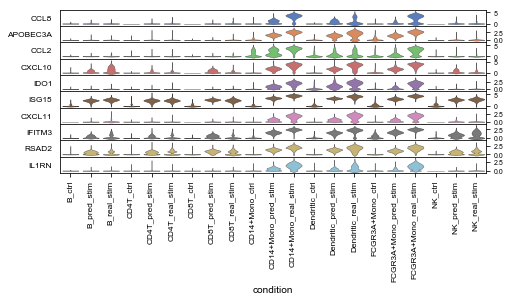

500
saving figure to file ../results/Figures/Supplemental Figure 5/stacked_violin_PCA_median_score_pbmc.pdf


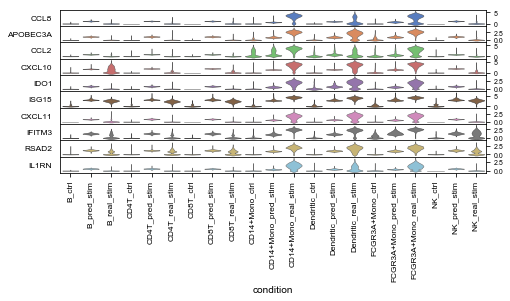

In [21]:
stacked_violin_plot(scgen_reconstructed_pbmc, "scGen", "a", "pbmc", "median_score")
stacked_violin_plot(pca_reconstructed_pbmc, "PCA", "c", "pbmc", "median_score")

500
(3500,)


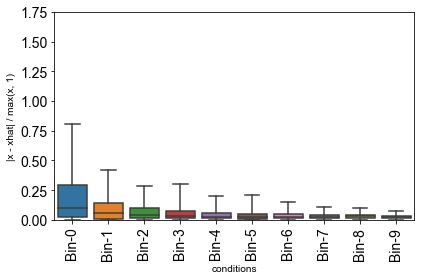

In [27]:
plot_boxplot(recon_data=scgen_reconstructed_pbmc, 
             method="scGen",
             data_name="pbmc", 
             n_genes=50, 
             restore=False, 
             score_type="median_score", 
             y_measure="AE:max(x, 1)", 
             scale="normal")

In [ ]:
plot_boxplot(recon_data=pca_reconstructed_pbmc, 
             method="PCA",
             data_name="pbmc", 
             n_genes=50, 
             restore=False,  
             score_type="median_score", 
             y_measure="AE:max(x, 1)", 
             scale="normal")

500
